In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Creare circles
X,y = make_circles(n_samples,
                   noise=0.03,
                     random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [6]:
import pandas as pd
circles = pd.DataFrame({"X0":X[:,0],
                        "X1":X[:,1],
                        "label":y})

circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [7]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

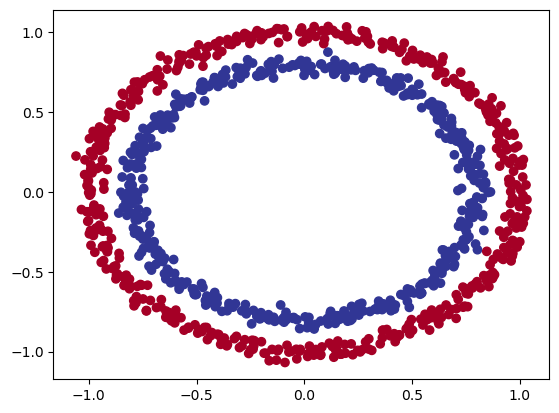

In [8]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [11]:
# Turn data into tensors

import torch
torch.__version__

'2.0.1'

In [12]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [13]:
X = torch.tensor(X).float()
y = torch.tensor(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(X), X.dtype, type(y), y.dtype

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [15]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [16]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
# Build a model
import torch
from torch import nn

# Make device agnostic
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [18]:
# Subclass the nn.Module class
class CircleModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
    
    # Define forward method
    def forward(self, X):
        return self.layer2(self.layer1(X))

# Instantiate model class & send to target device
model_0 = CircleModelNN().to(device)
model_0


CircleModelNN(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Replicating above model using torch.sequential
model_0 = nn.Sequential(nn.Linear(in_features=2,out_features=5),
                        nn.Linear(5,1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0018,  0.3428],
                      [ 0.4619,  0.4439],
                      [-0.5769, -0.2156],
                      [-0.0448, -0.5197],
                      [-0.6077, -0.0809]], device='mps:0')),
             ('0.bias',
              tensor([-0.1158,  0.4427,  0.2633, -0.5463, -0.6384], device='mps:0')),
             ('1.weight',
              tensor([[ 0.1871, -0.0918, -0.2561, -0.0307, -0.1986]], device='mps:0')),
             ('1.bias', tensor([0.0210], device='mps:0'))])

In [21]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of untrained_preds: {len(untrained_preds)}, Shape of untrained_preds: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape of test samples: {y_test.shape}")
print(f"First 5 predictions: {untrained_preds[:5]}")
print(f"First 5 labels: {y_test[:5]}")

Length of untrained_preds: 200, Shape of untrained_preds: torch.Size([200, 1])
Length of test samples: 200, Shape of test samples: torch.Size([200])
First 5 predictions: tensor([[ 0.0249],
        [ 0.1446],
        [-0.1601],
        [ 0.0768],
        [ 0.0442]], device='mps:0')
First 5 labels: tensor([1., 0., 1., 0., 1.])


### Setting up a loss function and optimizer

For regession you might want MAE or MSE

For classification, you might want Binary cross entropy or cross entropy

In [22]:
# Define loss and optimizer
# loss_fn = nn.BCELoss()
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activaton function built in
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

In [15]:
# Calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred.round()).sum().item()
    acc = correct / len(y_true) * 100
    return acc

## Training model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gad descent)

### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass activation)

Then we can convert our model's **prediction probabilities** to prediction labels by either rounding them or taking the argmax().

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[0:5]
y_logits

tensor([[ 0.0249],
        [ 0.1446],
        [-0.1601],
        [ 0.0768],
        [ 0.0442]], device='mps:0')

In [25]:
# We need the above output in the form below
y_test[0:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use the sigmoid activation function to convert logits to probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5062],
        [0.5361],
        [0.4601],
        [0.5192],
        [0.5111]], device='mps:0')

For our prediction probabilities, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y=1 (class 1)
* `y_pred_probs` < 0.5, y=0 (class 2)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> probs -> labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)))[:5])
# y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# How does both work?


print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Getting rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 0., 1., 1.], device='mps:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Building a testing & training loop

In [29]:
# Set seed
torch.manual_seed(42)

# Train the model
epochs = 1000

# put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # if this is with BCELoss()
    loss = loss_fn(y_logits, y_train) # BCELogitsloss is more numerically stable
    train_acc = accuracy(y_true=y_train,
                         y_pred=y_pred)

    # Reset the gradients to zero
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy(y_true=y_test,
                            y_pred=test_pred) # loss function does this in reverse order(pred, true)

        # Print loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss:.5f}, Train Acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 10, Loss: 0.69403, Train Acc: 50.00%, Test loss: 0.69486, Test acc: 50.00%
Epoch: 20, Loss: 0.69321, Train Acc: 46.50%, Test loss: 0.69426, Test acc: 50.00%
Epoch: 30, Loss: 0.69307, Train Acc: 50.38%, Test loss: 0.69473, Test acc: 48.00%


Epoch: 40, Loss: 0.69300, Train Acc: 51.25%, Test loss: 0.69479, Test acc: 46.00%
Epoch: 50, Loss: 0.69298, Train Acc: 51.12%, Test loss: 0.69469, Test acc: 47.50%
Epoch: 60, Loss: 0.69299, Train Acc: 52.00%, Test loss: 0.69463, Test acc: 46.50%
Epoch: 70, Loss: 0.69298, Train Acc: 51.50%, Test loss: 0.69473, Test acc: 45.50%
Epoch: 80, Loss: 0.69298, Train Acc: 51.38%, Test loss: 0.69477, Test acc: 45.50%
Epoch: 90, Loss: 0.69298, Train Acc: 51.50%, Test loss: 0.69470, Test acc: 45.50%
Epoch: 100, Loss: 0.69298, Train Acc: 51.38%, Test loss: 0.69468, Test acc: 45.50%
Epoch: 110, Loss: 0.69298, Train Acc: 51.38%, Test loss: 0.69469, Test acc: 45.50%
Epoch: 120, Loss: 0.69298, Train Acc: 51.12%, Test loss: 0.69467, Test acc: 45.00%
Epoch: 130, Loss: 0.69298, Train Acc: 51.12%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 140, Loss: 0.69298, Train Acc: 51.12%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 150, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 160

## Make predictions and evaluate the model

From the metrics, the model is not learning anything.

Make predictions

In [16]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

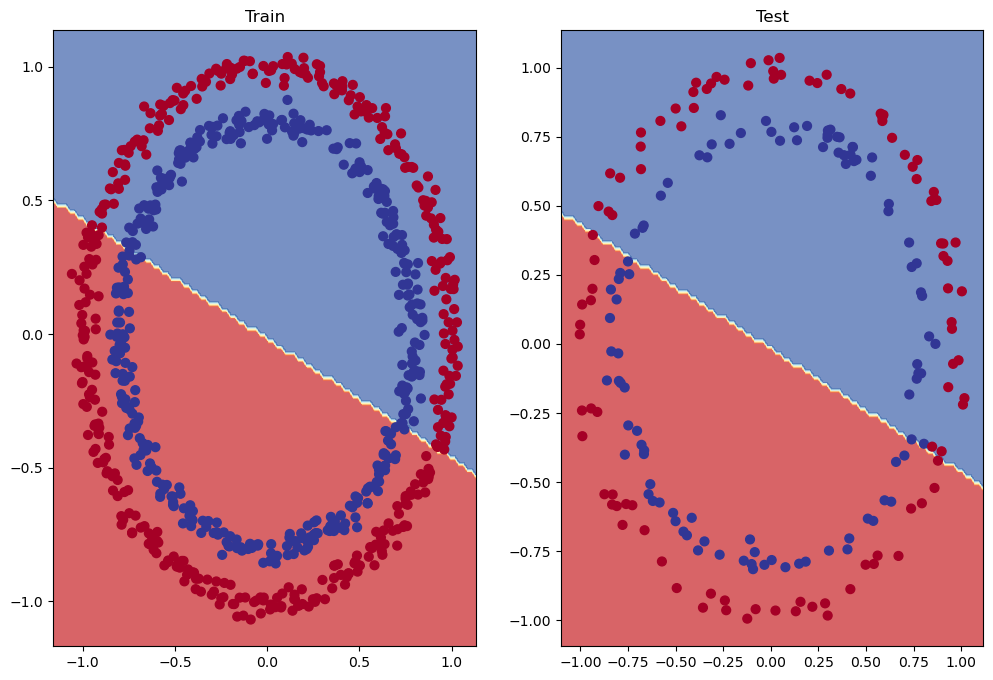

In [31]:
# Plot decision boundary
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

## Improving  a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 4 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model rather than the data.

Let's :
- Add hidden units: 5 to 10
- Increase number of layers: 2 to 3
- Increase the number of epochs: 100 -> 1000

In [32]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='mps:0'),
 tensor([1., 0., 0., 0., 1.], device='mps:0'))

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
    
    # Define forward method
    def forward(self, X):
        # z = self.layer1(X)
        # z = self.layer2(z)
        # z = self.layer3(z)
        # return z
        return self.layer3(self.layer2(self.layer1(X)))

# Instantiate model class & send to target device
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Replicate above model with sequential
model_1 = nn.Sequential(nn.Linear(in_features=2, out_features=10),
                        nn.Linear(10,10),
                        nn.Linear(10,1)).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='mps:0')),
             ('0.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='mps:0')),
             ('1.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.2663,  0.1232, -0.0157,

In [36]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Write a training loop
epochs = 1000

# Put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_true=y_train,
                         y_pred=y_pred)
    
    # Reset the gradients to zero 
    optimizer.zero_grad()

    # Backward pass (backpropagation)
    loss.backward()

    # Update weights (gradient descent)
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. Forward pass
        y_logits = model_1(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probs -> labels

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy(y_true=y_test,
                            y_pred=test_pred)

        # Print loss every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss:.5f}, Train Acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        


Epoch: 100, Loss: 0.69298, Train Acc: 51.12%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 200, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 300, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 400, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 500, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 600, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 700, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 800, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 900, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%
Epoch: 1000, Loss: 0.69298, Train Acc: 51.00%, Test loss: 0.69468, Test acc: 46.00%


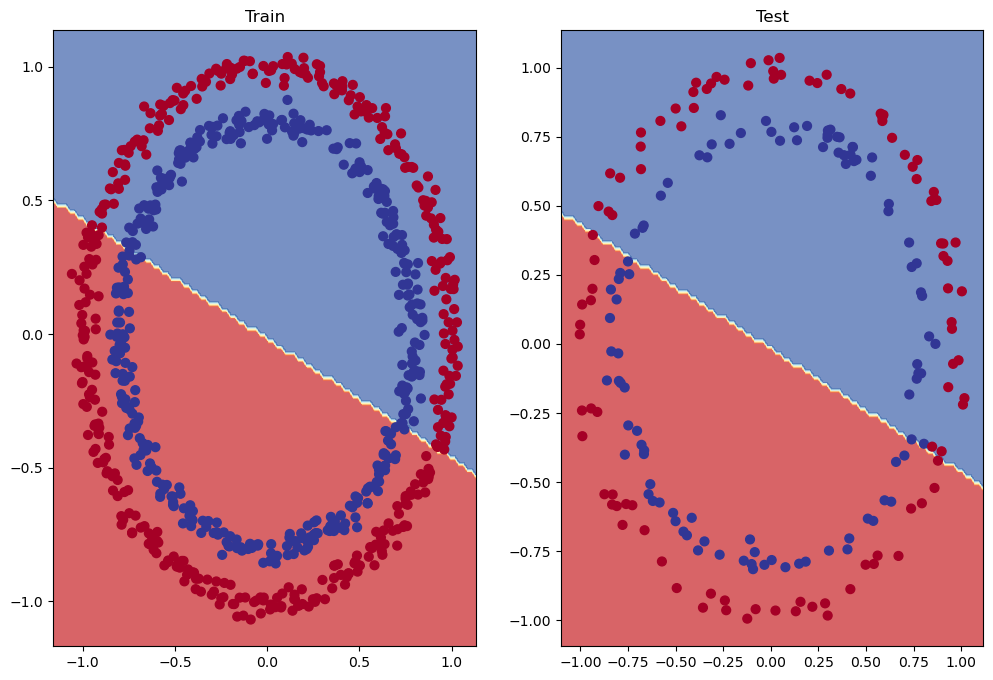

In [37]:
# Plot decision boundary
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_1, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

### 6. The missing piece: non-linearity

What patterns could you draw if you were given infinite amount of a straight and non-straight lines?

Or in machine learning terms, an infinite (but really is finiite) of linear and non linear functions?

### Recreating non linear data

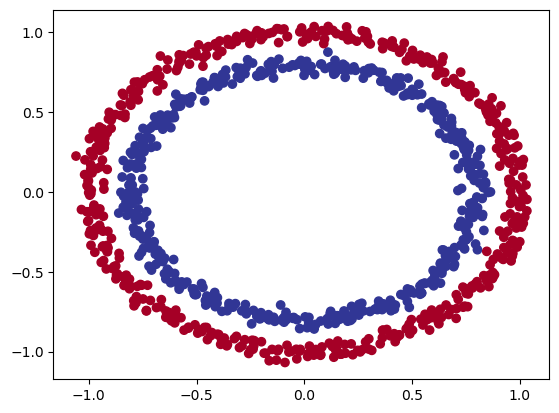

In [38]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

# Plot it
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [39]:
# Turn data into tensors
import torch
torch.__version__

X = torch.tensor(X).float()
y = torch.tensor(y).float()

# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Build a model

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.layer4 = nn.ReLU() # non-lienar activation function
    
    # Define forward method
    def forward(self, X):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(X)))))

# Instantiate model class & send to target device
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (layer4): ReLU()
)

In [40]:
# Replicate above model with sequential
model_3 = nn.Sequential(nn.Linear(in_features=2, out_features=10),
                        nn.ReLU(),
                        nn.Linear(10,10),
                        nn.ReLU(),
                        nn.Linear(10,1)).to(device)
model_3

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [44]:
# Random seeds
torch.manual_seed(42)

# Put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

epochs = 1000

for epoch in range(epochs):
    model_3.train()
    
    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probs -> labels

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_true=y_train,
                         y_pred=y_pred)
    
    optimizer.zero_grad() # reset gradients to zero
    loss.backward() # backpropagation
    optimizer.step() # gradient descent

    model_3.eval()
    with torch.inference_mode():
        
        test_logits = model_3(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test,
                            y_pred=y_pred)
        
        if (epoch+1) % 100 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss:.5f}, Train Acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 100, Loss: 0.67222, Train Acc: 66.88%, Test loss: 0.67912, Test acc: 59.50%
Epoch: 200, Loss: 0.65869, Train Acc: 65.25%, Test loss: 0.66977, Test acc: 58.50%
Epoch: 300, Loss: 0.63569, Train Acc: 68.25%, Test loss: 0.65128, Test acc: 58.50%
Epoch: 400, Loss: 0.59066, Train Acc: 83.00%, Test loss: 0.60969, Test acc: 76.50%
Epoch: 500, Loss: 0.50779, Train Acc: 94.88%, Test loss: 0.52921, Test acc: 93.50%
Epoch: 600, Loss: 0.38860, Train Acc: 99.38%, Test loss: 0.41284, Test acc: 98.00%
Epoch: 700, Loss: 0.26223, Train Acc: 99.88%, Test loss: 0.28903, Test acc: 99.50%
Epoch: 800, Loss: 0.16822, Train Acc: 100.00%, Test loss: 0.20011, Test acc: 99.50%
Epoch: 900, Loss: 0.11212, Train Acc: 100.00%, Test loss: 0.14592, Test acc: 100.00%
Epoch: 1000, Loss: 0.08053, Train Acc: 99.88%, Test loss: 0.11283, Test acc: 100.00%


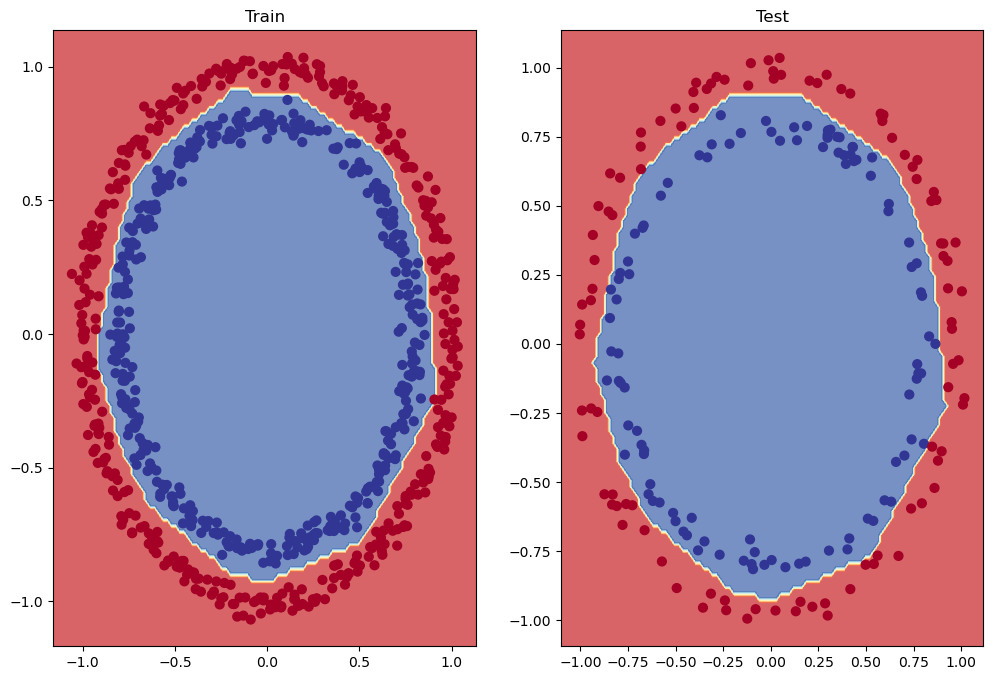

In [52]:
# Plot decision boundary
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_3, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_3, X=X_test, y=y_test)

### Multiclass classification

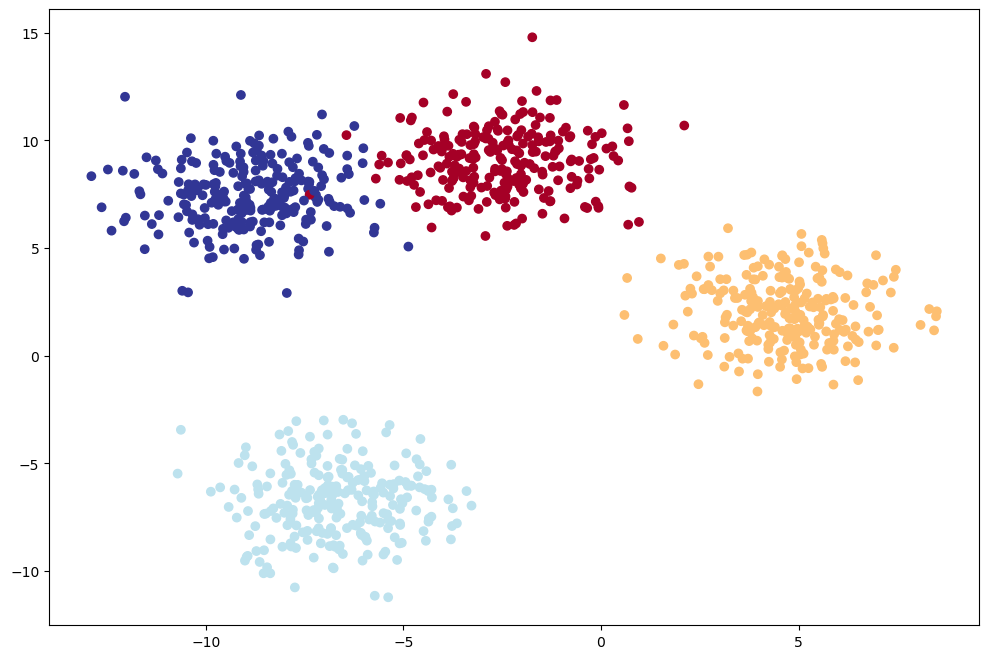

In [19]:
# Multiclass clasiification
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyerparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
NUM_SAMPLES = 1000

# Create data
X, y = make_blobs(n_samples=NUM_SAMPLES,
                  centers=NUM_CLASSES,
                  n_features=NUM_FEATURES,
                  random_state=RANDOM_SEED,
                  cluster_std=1.5)

# Plot it
plt.figure(figsize=(12,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [20]:
# Turn data into tensors
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.LongTensor)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [21]:
# Device agnostic
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [22]:
# Build a model
class MulticlassModel(nn.Module):
    def __init__(self, num_features, output_features, hidden_units=8):
        super().__init__()
        # Define layers
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
            )
    # Define forward method
    def forward(self, X):
        return self.linear_layer_stack(X)

# Instantiate model class & send to target device
model_4 = MulticlassModel(num_features=2,
                          output_features=4,
                          hidden_units=8).to(device)
model_4

MulticlassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [23]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [24]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

In [25]:
# Put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_train.to(device))
y_logits

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.2564, -1.2652, -1.0365, -0.3130],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.0502, -0.8423, -0.4798, -0.0988]], device='mps:0')

In [26]:
y_pred_probs = torch.softmax(model_4(X_train), dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='mps:0')
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [27]:
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

In [28]:
torch.argmax(y_pred_probs[0])

tensor(1, device='mps:0')

In [29]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
y_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='mps:0')

In [31]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
# Put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


In [33]:
# Training Loop & Testing loop
# Set random seed
torch.manual_seed(42)

# Put data on device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)

epochs = 5000

for epoch in range(epochs):
    model_4.train()
    
    # Forward pass
    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> probs -> labels

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    train_acc = accuracy(y_true=y_train,
                         y_pred=y_pred)
    
    optimizer.zero_grad() # reset gradients to zero
    loss.backward() # backpropagation
    optimizer.step() # gradient descent

    model_4.eval()
    with torch.inference_mode():
        
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test.long())
        test_acc = accuracy(y_true=y_test,
                            y_pred=test_pred)
        
        if (epoch+1) % 100 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss:.5f}, Train Acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 100, Loss: 0.63596, Train Acc: 98.00%, Test loss: 0.66873, Test acc: 98.50%
Epoch: 200, Loss: 0.20135, Train Acc: 99.00%, Test loss: 0.20655, Test acc: 100.00%
Epoch: 300, Loss: 0.07552, Train Acc: 99.12%, Test loss: 0.07158, Test acc: 99.50%
Epoch: 400, Loss: 0.04605, Train Acc: 99.25%, Test loss: 0.03991, Test acc: 99.50%
Epoch: 500, Loss: 0.03602, Train Acc: 99.12%, Test loss: 0.02862, Test acc: 99.50%
Epoch: 600, Loss: 0.03108, Train Acc: 99.12%, Test loss: 0.02284, Test acc: 99.50%
Epoch: 700, Loss: 0.02819, Train Acc: 99.25%, Test loss: 0.01932, Test acc: 99.50%
Epoch: 800, Loss: 0.02630, Train Acc: 99.25%, Test loss: 0.01696, Test acc: 99.50%
Epoch: 900, Loss: 0.02494, Train Acc: 99.25%, Test loss: 0.01530, Test acc: 99.50%
Epoch: 1000, Loss: 0.02388, Train Acc: 99.38%, Test loss: 0.01404, Test acc: 99.50%
Epoch: 1100, Loss: 0.02305, Train Acc: 99.38%, Test loss: 0.01305, Test acc: 99.50%
Epoch: 1200, Loss: 0.02238, Train Acc: 99.38%, Test loss: 0.01223, Test acc: 99.50%


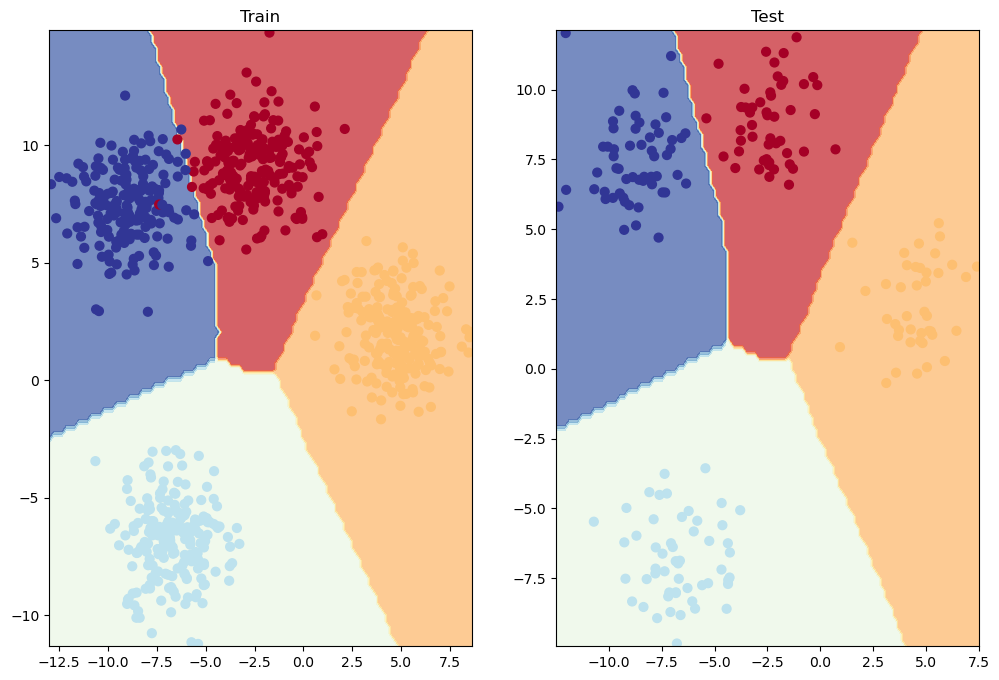

In [34]:
# Plot decision boundary
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_4, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_4, X=X_test, y=y_test)

### Evaluation metrics

* Accuracy

* Precision

* Recall

* F1-score

* Confusion matrix
